# Geolocation of Tree Inventory Dataset using Google Street View

This notebook outlines workflows for basic tree geolocation using pre-trained depth estimation models.

A tree inventory database contains the locations of "street trees" with latitude, longitude, genus, and a unique identifier code (IDX).

Google Street View imagery contains image of "street trees" which can be geolocated using an object detection model (YOLO) and depth estimator (MonoDepth2).




In [6]:
# Import Libraries

# PyTorch
import torch
from torchvision import transforms

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.image import imread
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# MonoDepth
# Make sure the path to the monodepth2 repository is correct
import sys
sys.path.insert(1, 'C:/users/talake2/Desktop/')
sys.path.insert(1, 'C:/users/talake2/Desktop/monodepth2/')

# Import necessary modules from monodepth2
from monodepth2 import networks
from monodepth2.utils import download_model_if_doesnt_exist
from monodepth2 import layers

# Analyses
import PIL.Image as pil
from PIL import UnidentifiedImageError
import os
import shutil
import numpy as np
import pandas as pd
import cv2
import random
import json
from math import asin, atan2, cos, degrees, radians, sin
from geopy.distance import geodesic
import geopandas as gpd
from shapely.geometry import Point
import pyproj




In [2]:
##### LOAD FUNCTIONS #####

def read_panoramic_image_and_metadata(img_folder, img_name):
    """
    Read panoramic image and its metadata from the specified folder.
    Returns the image, height, width, channels, pano_id, pano_rotation_value, pano_lat, pano_lon.
    """
    img_path = os.path.join(img_folder, img_name)
    json_path = img_path.replace('.jpg', '.metadata.json')
    
    try:
        # Read panoramic image
        img = imread(img_path)
        height, width, channels = img.shape
    except (FileNotFoundError, UnidentifiedImageError):
        # Handle the case where image file is not found or is not a valid image
        print(f"Image file not found or is not a valid image: {img_name}")
        return None
    
    try:
        # Read panoramic image metadata
        with open(json_path, 'r') as json_file:
            img_metadata = json.load(json_file)
    except FileNotFoundError:
        # Handle the case where metadata file is not found
        print(f"Metadata file not found for image: {img_name}")
        return None

    # Get metadata for panorama
    pano_id = img_metadata['panoId']
    pano_rotation_value = img_metadata['rotation']  # North
    pano_lat = img_metadata['lat']
    pano_lon = img_metadata['lng']

    return img, width, pano_id, pano_rotation_value, pano_lat, pano_lon


def calculate_pano_tree_angle(row, img_width, pano_rotation_north):
    """
    Calculate the angle of rotation of a tree in the panoramic image, based on the 
    vertical center of the bounding box given from a YOLO model.
    """
    # Extract vertical center of the tree bounding box
    tree_center_x = (row['xmin'] + row['xmax']) / 2
    # Calculate the angle relative to the north
    px_per_degree = (img_width/360) # eq. 45.5111
    tree_angle = tree_center_x / px_per_degree
    # Adjust the angle based on the north rotation value
    adjusted_angle = (tree_angle - pano_rotation_north) % 360
    return adjusted_angle


def calculate_pano_inventory_angle(pano_lon, pano_lat, tree_lon, tree_lat):
    '''
    Calculate the angle of rotation of a tree in the panoramic image, based on the
    known coordinates between two points (inventory tree and panoramic image origin)
    '''
    geodesic = pyproj.Geod(ellps='WGS84')
    fwd_azimuth, _, _ = geodesic.inv(pano_lon, pano_lat, tree_lon, tree_lat)
    inventory_tree_angle = fwd_azimuth % 360  # Convert from negative angle to positive
    return inventory_tree_angle

def get_point_at_distance(lat1, lon1, d, bearing, R=6371):
    """
    lat: initial latitude, in degrees
    lon: initial longitude, in degrees
    d: target distance from initial
    bearing: (true) heading in degrees
    R: optional radius of sphere, defaults to mean radius of earth

    Returns new lat/lon coordinate {d}km from initial, in degrees
    Source: https://stackoverflow.com/questions/7222382/get-lat-long-given-current-point-distance-and-bearing
    """
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    a = radians(bearing)
    d = d/1000 # Convert from Km to meters
    lat2 = asin(sin(lat1) * cos(d/R) + cos(lat1) * sin(d/R) * cos(a))
    lon2 = lon1 + atan2(
        sin(a) * sin(d/R) * cos(lat1),
        cos(d/R) - sin(lat1) * sin(lat2)
    )
    return (degrees(lat2), degrees(lon2),)


def load_monodepth2_model(encoder_path, depth_decoder_path):
    """
    Load a pretrained MonoDepth model that estimates disparity/depth.
    
    Args:
    - encoder_path (str): Path to the encoder model checkpoint.
    - depth_decoder_path (str): Path to the depth decoder model checkpoint.
    
    Returns:
    - encoder (torch.nn.Module): Loaded encoder model.
    - depth_decoder (torch.nn.Module): Loaded depth decoder model.
    """
    # Initialize encoder and depth_decoder
    encoder = networks.ResnetEncoder(18, False)
    depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

    # Load encoder model
    loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
    filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
    encoder.load_state_dict(filtered_dict_enc)

    # Load depth decoder model
    loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
    depth_decoder.load_state_dict(loaded_dict)

    # Set models to evaluation mode
    encoder.eval()
    depth_decoder.eval()

    return encoder, depth_decoder


def estimate_depth_with_monodepth2(encoder, depth_decoder, img_folder, img_name, min_depth, max_depth, stereo_scale_factor):
    """
    Estimate depth in a panoramic image using MonoDepth2.

    Args:
    - encoder (torch.nn.Module): Loaded encoder model.
    - depth_decoder (torch.nn.Module): Loaded depth decoder model.
    - img_path (str): Path to the panoramic image.
    - min_depth (float): Minimum depth for conversion.
    - max_depth (float): Maximum depth for conversion.
    - stereo_scale_factor (float): Stereo scale factor for depth adjustment.

    Returns:
    - metric_depth_resized (numpy.ndarray): Depth estimate on the panoramic image.
    """
    # Load and preprocess the input image
    img_path = os.path.join(img_folder, img_name)
    input_image = pil.open(img_path).convert('RGB')
    original_width, original_height = input_image.size
    feed_height = 320
    feed_width = 1024
    input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

    input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

    # Run MonoDepth2 to estimate disparity 
    with torch.no_grad():
        features = encoder(input_image_pytorch)
        outputs = depth_decoder(features)

    # Convert disparity to depth (meters) from MonoDepth2
    disp = outputs[("disp", 0)]
    disp_resized = torch.nn.functional.interpolate(disp, (original_height, original_width), mode="bilinear", align_corners=False)

    def disp_to_depth(disp, min_depth, max_depth):
        """Convert network's sigmoid output into depth prediction."""
        min_disp = 1 / max_depth
        max_disp = 1 / min_depth
        scaled_disp = min_disp + (max_disp - min_disp) * disp
        depth = 1 / scaled_disp
        return scaled_disp, depth

    scaled_disp, depth = disp_to_depth(disp_resized, min_depth, max_depth)

    # Multiply disparity by scaling factor to output depth (meters)
    metric_depth = stereo_scale_factor * depth.squeeze().cpu().numpy()

    # Depth estimate on Panoramic Image
    metric_depth_resized = metric_depth[:, :, np.newaxis]  # Expand dim

    return metric_depth_resized

In [3]:
# Geolocation Inputs

### Tree Inventory ###
# Read in Tree Inventory .csv file containing 'latitude' and 'longitude' columns information on tree locations
tree_inventory_df = pd.read_csv(r'C:\Users\talake2\Desktop\auto_arborist_cvpr2022_v015\auto_arborist_tfrecords_data\auto_arborist_tfrecords_csv\tfrecords_locs_all.csv')
# Create a GeoDataFrame from the tree_inventory_df
tree_geometry = [Point(lon, lat) for lon, lat in zip(tree_inventory_df['Longitude'], tree_inventory_df['Latitude'])]
tree_gdf = gpd.GeoDataFrame(tree_inventory_df, geometry=tree_geometry)

### Google Street View Panoramic Images ###
# Read Panoramic Images from Directory
# Define folder containing panoramic images and .JSON metadata files
img_folder = r'C:\Users\talake2\Desktop\geolocation-pano-testing-single'

### YOLO Model to Detect Trees ###
# Load a pretrained YOLO model that detects trees
model1_name = 'tree-detector-yolov5x-oct2323-autoarborist-25epochs'
model1_path = f'C:/Users/talake2/Desktop/auto_arborist_cvpr2022_v015/yolov5/runs/train/{model1_name}/weights/last.pt'
tree_model = torch.hub.load(r'C:/Users/talake2/Desktop/auto_arborist_cvpr2022_v015/yolov5', 'custom', path=model1_path, source='local')
tree_model.conf = 0.25  # confidence threshold (0-1)

# Paths for MonoDepth2 Encoder and Decoder
# https://github.com/nianticlabs/monodepth2
encoder_path = "C:/users/talake2/Desktop/monodepth2/models/mono+stereo_1024x320/encoder.pth"
depth_decoder_path = "C:/users/talake2/Desktop/monodepth2/models/mono+stereo_1024x320/depth.pth"


YOLOv5  v7.0-226-gdd9e338 Python-3.10.13 torch-2.1.2 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)

Fusing layers... 
autoarborist_architecture_YOLOv5x summary: 322 layers, 86173414 parameters, 0 gradients, 203.8 GFLOPs
Adding AutoShape... 


In [ ]:
# Revise Tree Geolocation to Accept Multiple 'Nearest Trees' If Detected

In [4]:
# Hold resulting data from geolocation
# Create an empty DataFrame to store the results
tree_geolocation_results_df = pd.DataFrame(columns=['PanoID', 'Pano_Origin_Lon', 'Pano_Origin_Lat', 'Tree_Inventory_Lon', 'Tree_Inventory_Lat', 'Estimated_Tree_Lon', 'Estimated_Tree_Lat', 'True Depth', 'Estimated_Depth', 'RMSE'])

# Iterate over each image in the directory.
for img_name in os.listdir(img_folder):
    if img_name.endswith('.jpg'):
        
        # Read Panoramic image and Metadata .JSON file, return image and metadata
        img, width, pano_id, pano_rotation_value, pano_lat, pano_lon = read_panoramic_image_and_metadata(img_folder, img_name)
        
        # Calculate distance between tree inventory records and panoramic image
        print(f'Locating Tree Inventory Data Nearest to: ', pano_lat, pano_lon)
        tree_inventory_df['distance'] = tree_inventory_df.apply(
            lambda row: geodesic((pano_lat, pano_lon), (row['Latitude'], row['Longitude'])).meters, axis=1)

        # Get inventory tree nearest to the panoramic image
        nearest_tree = tree_inventory_df.nsmallest(10, 'distance')
        nearest_tree = nearest_tree[nearest_tree['distance'] <= 15]
        
        if not nearest_tree.empty:
    
            # Print: Which Inventory Trees Are Found Nearest to Panoramic Images
            print(f'Found', len(nearest_tree['distance'].values.tolist()), 'Tree Inventory Sample(s)' )
            for t in range(len(nearest_tree['distance'].values.tolist())):
                print(f"Found Inventory Tree", int(nearest_tree['distance'].values.tolist()[t]), 
                      "meters from image. Tree IDX:", nearest_tree['Tree Location IDX'].values.tolist()[t], 
                      "Genus", nearest_tree['Genus'].values.tolist()[t])

            # Apply YOLO model to detect all trees in image
            model_results = tree_model(img) # Run YOLO Inference
            model_results_df = model_results.pandas().xyxy[0] # Store YOLO results

            # Calculate angle between pano and predicted tree from Yolo model
            pano_tree_angles = []
            for index, row in model_results_df.iterrows():
                pano_tree_angle = calculate_pano_tree_angle(row, width, pano_rotation_value)
                pano_tree_angles.append(pano_tree_angle)

            # Load MonoDepth2 Model for Depth Estimation on Panoramic image
            encoder, depth_decoder = load_monodepth2_model(encoder_path, depth_decoder_path)     

            # Estimate Depth with MonoDepth2
            metric_depth_resized = estimate_depth_with_monodepth2(encoder, depth_decoder, img_folder, img_name, min_depth=0.1, max_depth=100, stereo_scale_factor=1.5)
        
            
            # Iterate through nearest trees < 15m from panoramic image:
            for t in range(len(nearest_tree['Tree ID'].values.tolist())):

                # Calculate the true angle between the pano image origin and the inventory tree
                pano_inventory_angle = calculate_pano_inventory_angle(pano_lon, pano_lat, nearest_tree['Longitude'].iloc[t], nearest_tree['Latitude'].iloc[t])
                print(f'Angle From Panoramic Image to Inventory Tree: ', pano_inventory_angle)

                # Get closet matching angle between true (pano-inventory-angle) and estimate (pano-tree-angle)
                closest_match = min(pano_tree_angles, key=lambda x:abs(x - pano_inventory_angle))  

                print(f'Angle From Panoramic Image to Detected Tree: ', closest_match)

                # Get Bounding Box of Inventory Tree From YOLO Model
                xmin = int(model_results_df.iloc[pano_tree_angles.index(closest_match)][0])
                ymin = int(model_results_df.iloc[pano_tree_angles.index(closest_match)][1])
                xmax = int(model_results_df.iloc[pano_tree_angles.index(closest_match)][2])
                ymax = int(model_results_df.iloc[pano_tree_angles.index(closest_match)][3])

                # Crop the depth map to the tree matched from panoramic image to inventory
                cropped_depth = metric_depth_resized[ymin:ymax, xmin:xmax, 0]
                
                # Estimate depth as the center point of the bounding box for the detected tree
                est_tree_depth = cropped_depth[cropped_depth.shape[0] // 2, cropped_depth.shape[1] // 2].item()

                print(f'Estimated Depth:', est_tree_depth)
                print(f'True Depth:', nearest_tree['distance'].iloc[t])

                # Get latitude and longitude estimate for tree given origin, distance, and angle
                #est_tree_lat, est_tree_lon = get_point_at_distance(pano_lat, pano_lon, est_tree_depth, pano_tree_angles[pano_tree_angles.index(closest_match)])
                est_tree_lat, est_tree_lon = get_point_at_distance(pano_lat, pano_lon, est_tree_depth, pano_inventory_angle)

                # Error Assessment: Calculate Distance Between Tree Inventory and Detected Tree
                # Calculate difference between (pano-tree) distance and estimated (pano-tree) distance
                rmse = np.sqrt(((est_tree_depth - nearest_tree['distance'].values.tolist()[0])**2))
                print(f'Root Mean Squared Error (RMSE): {rmse:.6f} meters')

                # Append the results to the DataFrame
                tree_geolocation_results_df = tree_geolocation_results_df.append({
                    'Pano_ID': pano_id,
                    'Pano_Origin_Lon': pano_lon,
                    'Pano_Origin_Lat': pano_lat,
                    'Tree_Inventory_Lon': nearest_tree['Longitude'].iloc[t],
                    'Tree_Inventory_Lat': nearest_tree['Latitude'].iloc[t],
                    'Estimated_Tree_Lon': est_tree_lon,
                    'Estimated_Tree_Lat': est_tree_lat,
                    'True Depth': nearest_tree['distance'].iloc[t],
                    'Estimated_Depth': est_tree_depth,
                    'RMSE': rmse
                }, ignore_index=True)
    

                        

C:\Users\talake2\AppData\Local\anaconda3\envs\tensorflow_210\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Locating Tree Inventory Data Nearest to:  40.76045263352223 -73.78032659207999
Found 1 Tree Inventory Sample(s)
Found Inventory Tree 6 meters from image. Tree IDX: 70455908-0c5d-11ec-8a4e-23392b276719 Genus zelkova


C:\Users\talake2\AppData\Local\anaconda3\envs\tensorflow_210\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Angle From Panoramic Image to Inventory Tree:  46.129958560891104
Angle From Panoramic Image to Detected Tree:  57.39618921279907
Estimated Depth: 12.225837707519531
True Depth: 6.628504480107628
Root Mean Squared Error (RMSE): 5.597333 meters


C:\Users\talake2\AppData\Local\Temp\ipykernel_9484\2481838509.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tree_geolocation_results_df = tree_geolocation_results_df.append({


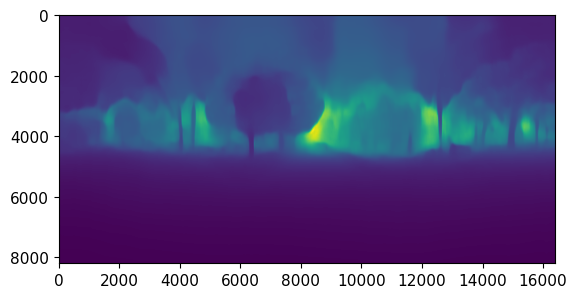

In [7]:
plt.imshow(metric_depth_resized)

plt.show();

In [ ]:
# Geolocate Trees From Object Detection Model and Depth Estimation

In [ ]:
# Iterate over each image in the directory.
for img_name in os.listdir(img_folder):
    if img_name.endswith('.jpg'):
        
        # Read Panoramic image and Metadata .JSON file, return image and metadata
        img, width, pano_id, pano_rotation_value, pano_lat, pano_lon = read_panoramic_image_and_metadata(img_folder, img_name)
        
        print(f'Processing Pano ID:', pano_id, 'from location:', pano_lat, pano_lon, 'with north bearing:', pano_rotation_value)
        
        # Calculate distance between tree inventory records and panoramic image
        tree_inventory_df['distance'] = tree_inventory_df.apply(
            lambda row: geodesic((pano_lat, pano_lon), (row['Latitude'], row['Longitude'])).meters, axis=1)

        # Get inventory tree nearest to the panoramic image
        nearest_tree = tree_inventory_df.nsmallest(1, 'distance')
        nearest_tree = nearest_tree[nearest_tree['distance'] <= 15]

        if not nearest_tree.empty:
            print(f"Found Inventory Tree", nearest_tree['distance'].values.tolist()[0], " meters from Pano: ", nearest_tree['Tree Location IDX'].values.tolist()[0], nearest_tree['Genus'].values.tolist()[0])
            
            # Calculate the angle between the pano image origin and the inventory tree
            pano_inventory_angle = calculate_pano_inventory_angle(pano_lon, pano_lat, nearest_tree['Longitude'].iloc[0], nearest_tree['Latitude'].iloc[0])
            
            # Apply YOLO model to detect all trees
            model_results = tree_model(img) # Run YOLO Inference
            model_results_df = model_results.pandas().xyxy[0] # Store YOLO results
            #print(model_results_df)
            
            # Match inventory_angle to tree_angle
            angle_threshold = 5.0 # degrees
            
            # Calculate the angle between the pano image and detected trees
            for index, row in model_results_df.iterrows():
                pano_tree_angle = calculate_pano_tree_angle(row, width, pano_rotation_value)
                if abs(pano_inventory_angle - pano_tree_angle) < angle_threshold:
                   # Get bounding box for detected tree in the panoramic image
                    xmin, ymin, xmax, ymax = (
                        int(row['xmin']),
                        int(row['ymin']),
                        int(row['xmax']),
                        int(row['ymax']))
                    break # Once a 'matching' tree is found, continue
                    
            # Load MonoDepth2 Model for Depth Estimation
            encoder, depth_decoder = load_monodepth2_model(encoder_path, depth_decoder_path)     
            
            # Estimate Depth with MonoDepth2
            metric_depth_resized = estimate_depth_with_monodepth2(encoder, depth_decoder, img_folder, img_name, min_depth=0.1, max_depth=100, stereo_scale_factor=1.5)
            
            # Crop the depth map to the tree matched from panoramic image to inventory
            cropped_depth = metric_depth_resized[ymin:ymax, xmin:xmax, :]

            # Estimate depth at the mid-point of the detected tree bounding box
            est_tree_depth = cropped_depth[cropped_depth.shape[0] // 2, cropped_depth.shape[1] // 2].item()
            
            # Get latitude and longitude estimate for tree given origin, distance, and angle
            est_tree_lat, est_tree_lon = get_point_at_distance(pano_lat, pano_lon, est_tree_depth, pano_tree_angle)
            
            # Error Assessment: Calculate Distance Between Tree Inventory and Detected Tree
            # Calculate difference between (pano-tree) distance and estimated (pano-tree) distance
            rmse = np.sqrt(((est_tree_depth - nearest_tree['distance'].values.tolist()[0])**2))
            print(f'Root Mean Squared Error (RMSE): {rmse:.6f} meters')
            
            

In [ ]:
# Plot Panoramic location and nearest trees

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import img_tiles

# Define the bounding box for the plot
bbox = [
    min(pano_lon, nearest_tree['Longitude'].min()) - 0.0003,
    max(pano_lon, nearest_tree['Longitude'].max()) + 0.0003,
    min(pano_lat, nearest_tree['Latitude'].min()) - 0.0003,
    max(pano_lat, nearest_tree['Latitude'].max()) + 0.0003
]

# Plotting
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Use Google Maps satellite imagery as the basemap
google_tiles = img_tiles.GoogleTiles(style="street")
ax.add_image(google_tiles, 14, interpolation='spline36')

# Plot the panoramic image location as a blue X
ax.plot(pano_lon, pano_lat, 'bx', label='Panoramic Image')

# Plot the nearest_trees locations as green triangles
ax.scatter(nearest_tree['Longitude'], nearest_tree['Latitude'], marker='^', c='green', label='Nearest Inventory Tree')

ax.scatter(est_tree_lon, est_tree_lat, marker='o', c='orange', label='Estimated Tree Location')

# Set the extent for zooming out
ax.set_extent(bbox, crs=ccrs.PlateCarree())

# Adding labels and legend
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Panoramic Image and Nearest Trees Locations')
ax.legend()

# Show the plot
plt.show()